In [22]:
# Imports :
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
import math
import pandas as pd

In [23]:
df = pd.read_table('horse_data23.txt')

In [24]:
df.head()

,experiment,horse,lameLeg,lameSide,lameForeHind,A,S,W,pc1,pc2,pc3,pc4
1,1,B1,none,none,none,-0.002304,-4.513454,-0.013884,0.121519,0.031750,0.046953,0.144889
2,1,B1,none,none,none,-0.045322,-4.453982,-0.012962,0.125487,-0.001296,0.043845,0.125972
3,1,B1,none,none,none,-0.010038,-6.086829,-0.008943,0.122509,-0.096972,0.007267,0.034485
4,1,B1,none,none,none,-0.001488,-4.520627,-0.009451,0.115689,0.129737,0.029682,0.128926
16,1,B2,none,none,none,-0.126048,-5.303123,0.002075,0.114835,-0.032392,0.018564,-0.118194


In [25]:
df.columns

Index(['experiment', 'horse', 'lameLeg', 'lameSide', 'lameForeHind', 'A', 'S',
       'W', 'pc1', 'pc2', 'pc3', 'pc4'],
      dtype='object')

In [26]:
class_names = np.unique(df['lameLeg'])

y = df['lameLeg']

c  =  np.array(pd.get_dummies(y)) @ np.array([1,2,3,4,5])

In [27]:
c

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 4, 4, 2, 2, 1,
       1, 3, 5, 5, 4, 4, 2, 2, 1, 1, 3, 4, 4, 2, 2, 1, 1, 3, 5, 5, 4, 4,
       2, 2, 1, 1, 3, 5, 5, 4, 4, 2, 2, 1, 1, 3, 5, 5, 4, 4, 2, 2, 1, 1,
       3, 5, 5, 4, 4, 2, 2, 1, 1, 3, 5, 5, 4, 4, 2, 2, 1, 1, 3])

In [6]:
for i in range(5):
    print("number of elements in class", class_names[i], ":")
    print(sum(c == i+1))

number of elements in class left:fore :
16
number of elements in class left:hind :
16
number of elements in class none :
23
number of elements in class right:fore :
16
number of elements in class right:hind :
14


# 1.

In [28]:
X1 = df[['A', 'W']]

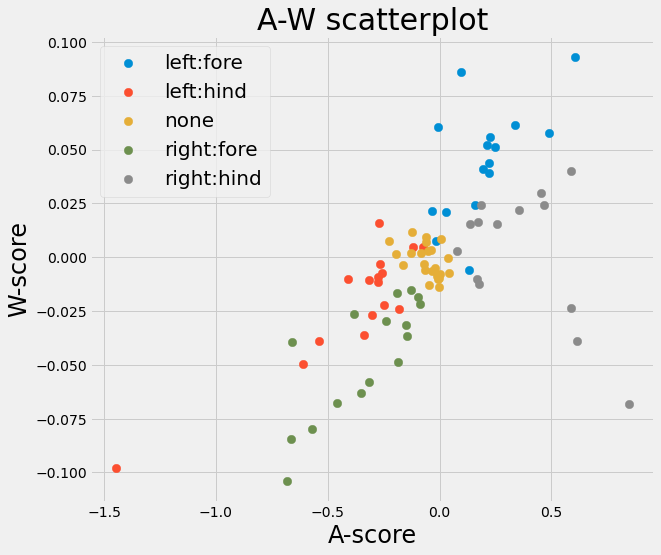

In [44]:
plt.figure(figsize=(9,8))
for i in range(5):
    index = i+1 == c
    plt.scatter(X1['A'][index], X1['W'][index], s = 70, label = class_names[i])

plt.legend(prop = {"size":20})
plt.title('A-W scatterplot', fontsize = 30)
plt.ylabel('W-score', fontsize = 24)
plt.xlabel('A-score', fontsize = 24)
plt.show()

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import torch


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3)

RandomForestModel = RandomForestClassifier(n_estimators=1000)
RandomForestModel.fit(X_train, y_train)
print("RandomForestModel's accuracy:", sum(RandomForestModel.predict(X_test) == y_test)/len(y_test))

###################################################################

X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3)

KNeighborsModel = KNeighborsClassifier(n_neighbors=3)
KNeighborsModel.fit(X_train, y_train)
print("K-NeigborsModel's accuracy:", sum(KNeighborsModel.predict(X_test) == y_test)/len(y_test))

##################################################################

X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3)

LogisticModel = LogisticRegression()
LogisticModel.fit(X_train, y_train)
print("LogisticModel's accuracy:", sum(LogisticModel.predict(X_test) == y_test)/len(y_test))

##################################################################

X_train, X_test, y_train, y_test = train_test_split(X1.to_numpy(), c-1, test_size=0.3, )

# Parameters for neural network classifier
n_hidden_units = 10     # number of hidden units
n_replicates = 1        # number of networks trained in each k-fold
max_iter = 1000000         # stop criterion 2 (max epochs in training)
tolerance=1e-6
M = 2

X_train, X_test = torch.tensor(X_train, dtype=torch.float), torch.tensor(X_test, dtype=torch.float)
y_train, y_test = torch.tensor(y_train), torch.tensor(y_test)

model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
                    torch.nn.Tanh(),   # 1st transfer function,
                    torch.nn.Linear(n_hidden_units, 5), # H hidden units to 1 output neuron
                    torch.nn.Sigmoid() # final tranfer function
                    )
#loss_fn = torch.nn.BCELoss()
loss_fn = torch.nn.CrossEntropyLoss()


logging_frequency = 1000 # display the loss every 1000th iteration
best_final_loss = 1e100
for r in range(n_replicates):
    net = model()

    torch.nn.init.xavier_uniform_(net[0].weight)
    torch.nn.init.xavier_uniform_(net[2].weight)
    
    optimizer = torch.optim.Adam(net.parameters())
    
    # Train the network while displaying and storing the loss
    learning_curve = [] # setup storage for loss at each step
    old_loss = 1e6
    for i in range(max_iter):
        y_est = net(X_train) # forward pass, predict labels on training set
        loss = loss_fn(y_est, y_train) # determine loss
        loss_value = loss.data.numpy() #get numpy array instead of tensor
        learning_curve.append(loss_value) # record loss for later display
        
        # Convergence check, see if the percentual loss decrease is within
        # tolerance:
        p_delta_loss = np.abs(loss_value-old_loss)/old_loss
        if p_delta_loss < tolerance: break
        old_loss = loss_value
        
        # do backpropagation of loss and optimize weights 
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        
    
    if loss_value < best_final_loss: 
        best_net = net
        best_final_loss = loss_value
        best_learning_curve = learning_curve
    
# Return the best curve along with its final loss and learing curve
#return best_net, best_final_loss, best_learning_curve


# Determine estimated class labels for test set
y_sigmoid = net(X_test)

y_test = y_test.type(dtype=torch.uint8)

print("NN's accuracy:", sum(np.argmax(y_sigmoid.detach().numpy(),axis=1)== np.array(y_test))/len(y_test))

RandomForestModel's accuracy: 0.6538461538461539
K-NeigborsModel's accuracy: 0.6538461538461539
LogisticModel's accuracy: 0.4230769230769231
NN's accuracy: 0.38461538461538464


# 2.

In [35]:
X2 = df[['pc3', 'pc4']]

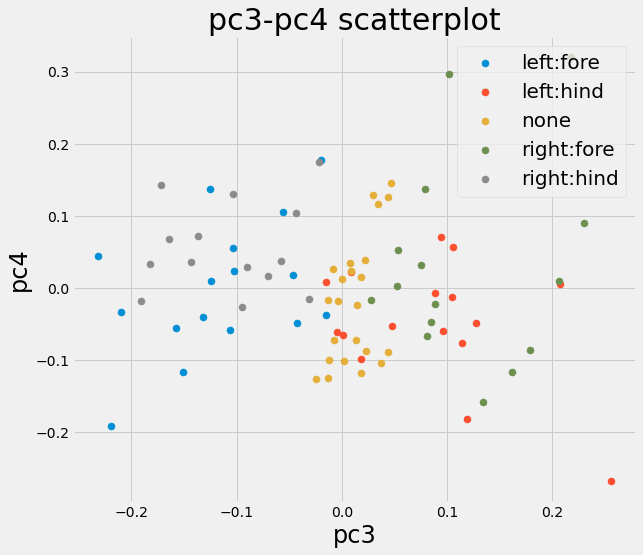

In [45]:
plt.figure(figsize=(9,8))
for i in range(5):
    index = i+1 == c
    plt.scatter(X2['pc3'][index], X2['pc4'][index], s = 50, label = class_names[i])
plt.legend(prop = {"size":20})
plt.title('pc3-pc4 scatterplot', fontsize = 30)
plt.ylabel('pc4', fontsize = 24)
plt.xlabel('pc3', fontsize = 24)
plt.show()

# 3.

In [105]:
X3 = df[['S', 'W', 'pc3', 'pc4']]